# Natural Language Processing with Disaster Tweets

## Introduction

Social media has connected people thoughout the world and has changed the way in which people communicate with one another. It has given us the ability to spread information from one side of the globe to the next in a matter of seconds. However, this ability of social media is not limited to spreading funny cat videos. Social media journalism is a growing occupancy and has the potential to provide mass amounts of people with the latest news and varied opinions. Even when it is not an occupation of the person making a post, many posts on social media can be informative about current events. Since these posts are coming from people 'on the ground', they can be reported before any main-stream news organization has people reporting on an incident. It is therefore of interest to identify when someone is posting about an important incident.

This notebook serves two purposes. The first is to investigate the performance of neural networks (NN) as natural language processing (NLP) classifiers. Specifically, the neural networks used in this post make use of long short-term memory (LSTM) layers. The NLP task here is to consider twitter messages (tweets) and classify whether a tweet is about a disaster or not. This has obvious benefits to relief orgonaizations or news agencies who need to have a quick response to disasters. The data used here comes from a Kaggle competition for creating the best classifier for this task. The second purpose of this notebook is as a basic tutorial to natural language processing using LSTMs with the [Pytorch](https://pytorch.org/) framework. This tutorial will consider how to pre-process the data, how to build a basic classifier implementation and then various techniques for improving the model. After considering these different techniques, these models will be evaluated against the competition's test dataset to get a true measure of the performance of each variant.

## Background

This section provides background to the three core concepts used in this NLP task. The first is a brief description of a neural network and how it works, the second is the technique used for converting words into a format that can be processed by a neural network. The last second is a type of neural network layer designed specifically for processing words in a sentence.

### Neural network

At a high level, a neural network is a machine learning model that is able to approximate, to any degree of accuracy, a function or relationship. For supervised learning, this is achieved by providing the network with training data from which it can learn the required relationships between variables. Why the neural network is able to approximate any function to any degree of accuracy is due to the fact that there is no limit on how complicated the model can become by adding more nodes and/or layers. A feed forward neural network takes a number of real valued inputs and though a series of weighted summations and transformations in the hidden layers, is able to produce a required number of outputs in the output layer. The output can then be used to make inferences or predictions about the data. The most common way of improving a neural network is a process known as gradient descent backpropagation. 

### Word embeddings

In most cases, raw text is not compatible with machine learning (ML) models. To work with text data, words are usually first converted into a form a model can understand. The most common format of information that models understand is a vector of real valued numbers. The process of converting text to a vector is known as vectorization. This usually involves collecting a vocabulary of words that are encountered in the NLP problem. A mapping is then made between these words and some vector representation of each word. The vector representation of a word is known as an embedding. An important aspect of embeddings is that for words with similar meaning, their embedding vectors should be close in the embedding vector space. The goal with embeddings is then to find the mapping of words to embeddings that is best able to place similar words close to each other in the embeddings space. Thankfully, this mapping can be learnt from the training data. 

### Long short-term memory

Often in natural language processing, it is not enough to know the immediate dependences between consecutive words in a sentence. Information that was stated earlier in a sentence can sometimes be key to understanding the meaning of words later in a sentence. LSTMs are used to resolve this issue by retaining information for longer periods of time. The core unit of a LSTM neural network is a block referred to as a cell. The information that is fed into these cells is the information at a particular time $x_t$, the previous cell state $c_{t-1}$ and the previous hidden state $h_{t-1}$. The output of the cell is the cell state and the hidden state. The cell state can be seen as the long-term memory while the hidden state is the short term memory.

The cells have three stages or 'gates'. The first is the <b>forget gate</b>. This stage determines whether the information in the cell state is relavent or not. This decision is made depending on the values of $x_t$ and $h_{t-1}$. If the cell state is determined to be irrelevent, the cell state will be forgotten. The second gate is the <b>input gate</b>. This gate determines how important the input $x_t$ is, in the context of the short term memory $h_{t-1}$. How much the current input and the previous hidden state contributes towards the current state of the cell is determined at this stage. The final stage is the <b>output gate</b>. This gate is used to determine what parts of the cell state are used as the output state of the cell. For a more detailed and mathematical explaination of LSTMs, please check out [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) website.

## Data used and data preparation

### Data cleaning

The data used in this notebook comes from the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started) Kaggle competition. The aim of this competition is to create a natural language processing machine learning model that is able to predict whether a given twitter message is reporting about an actual disaster or simply contains words that might be misleading. This kind of sentiment analysis may be important to disaster relief orgonaizations or news agencies who require a quick response time for a reported disaster. The data files and further information on the competition and motivation behind it can be found [here](https://www.kaggle.com/competitions/nlp-getting-started). This post makes use of [Pandas](https://pandas.pydata.org/) to load and handle the csv data files. To load and check the data:

In [2]:
import pandas as pd

train_df = pd.read_csv("../data/train.csv", index_col=0)
test_df = pd.read_csv("../data/test.csv", index_col=0)
train_df.head(5)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Before a model can do any NLP on the data, the data needs to be cleaned. How one cleans data is highly dependent on the application of the data. We know that the data will be run through a NN and that the NN will use word embeddings. Tweets usually contain a lot of noise in the form of random symbols, punctuation, emojicons and other text characters that do not necessarily add to the sentiment of a message. For example, consider the following two tweets:

<blockquote style="
   margin: 1em 20px;
	padding: 10px;
	border: 2px solid #1DA1F2;
	background-color: #d7ebf7;
	color: #555;
	font-size: 100%;
	text-align: justify;
    border-radius: 10px;
	-webkit-border-radius: 10px; ">That moment when ur about to win a mini uhc and than get blown up by a creeper and get kicked for flying..... So salty rn...!!!??</blockquote>

<blockquote style="
   margin: 1em 20px;
	padding: 10px;
	border: 2px solid #1DA1F2;
	background-color: #d7ebf7;
	color: #555;
	font-size: 100%;
	text-align: justify;
    border-radius: 10px;
	-webkit-border-radius: 10px; ">China\x89Ûªs stock market crash this summer has sparked interest from bargain hunters and bulls betting on a rebound. D\x89Û_ http://t.co/1yggZziZ9o</blockquote>

The first tweet contains repeated punction that is not necessary to understand the sentiment of the message. The second tweet contains character codes for non-standard symbols. In addition, the second tweet contains a website link which adds no additional information on what the tweet is about.

Since we do not want the vocabulary for the embeddings to be cluttered with this noise, the first step in cleaning the data is to remove the noise from each message. Following [this](https://catriscode.com/2021/05/01/tweets-cleaning-with-python/) guide on how to clean tweets in Python, we end up with the following function

In [3]:
import re

def clean_tweet(tweet):
    
    if type(tweet) == float:                   #Ignore purely numeric tweets
        return ""
    
    temp = tweet.lower()                       #Standardize to lowercase
    temp = re.sub("'", "", temp)               #Avoid removing concatenations
    temp = re.sub("@[A-Za-z0-9_]+","", temp)   #Remove mentions
    temp = re.sub("#[A-Za-z0-9_]+","", temp)   #Remove hashtags
    temp = re.sub(r"http\S+", "", temp)        #Remove links
    temp = re.sub("[()!?]", "", temp)          #Remove punctuation
    temp = re.sub("\[.*?\]", "", temp)         #Remove punctuation
    temp = re.sub("[^a-z0-9 ]", "", temp)      #Remove non-alphanumeric characters
    temp = temp.strip()
    return temp

Applying this function to the previous two tweets we obtain:

<blockquote style="
   margin: 1em 20px;
	padding: 10px;
	border: 2px solid #1DA1F2;
	background-color: #d7ebf7;
	color: #555;
	font-size: 100%;
	text-align: justify;
    border-radius: 10px;
	-webkit-border-radius: 10px; ">that moment when ur about to win a mini uhc and than get blown up by a creeper and get kicked for flying so salty rn</blockquote>

<blockquote style="
   margin: 1em 20px;
	padding: 10px;
	border: 2px solid #1DA1F2;
	background-color: #d7ebf7;
	color: #555;
	font-size: 100%;
	text-align: justify;
    border-radius: 10px;
	-webkit-border-radius: 10px; ">chinas stock market crash this summer has sparked interest from bargain hunters and bulls betting on a rebound d</blockquote>

Except for the single 'd' character left from the URL in the second tweet, these tweets are looking more clean and in a form that can be converted into embeddings without adding too many unnecessary words to the embedding vocabularly. Some tweets contain only noise and will therefore result in the empty string when the above cleaning function is applied. These tweets are removed from the training data. Cleaning can be done with the following code:

In [4]:
train_df['cleaned'] = train_df['text'].apply(clean_tweet)
train_df = train_df[train_df['cleaned'] != '']

test_df['cleaned'] = test_df['text'].apply(clean_tweet)
test_df = test_df[test_df['cleaned'] != '']

### Class balancing

An important consideration to have when dealing with any form of classification is the class distribution. Many machine learning models are sensitive to an imbalanced dataset and neurl networks are no exception. This kind of sensitivity means that a classifier will learn to be bias towards the majority class, usually classifying more entries to that class than should be. To identify if the dataset is imbalanced, a count of the training instances for each class is needed:

In [5]:
train_df[['text', 'target']].groupby('target').count()

,text
target,
0,4341
1,3271


The dataset is skew by over $1000$ entries. Although there are a couple of different methods that can balance the classes, the most simple and the one used here is undersampling from the majority class. The majority class will be randomly sampled without replacement until both classes have the same number of entries. The sampled majority class can then be combined with all the instances from the minority class to create a new balance training dataset. Here we utilize some Pandas' functions to sample, combine the instances and reshuffle the dataset:

In [6]:
majority = train_df[train_df['target'] == 0].sample(n=3271, replace=False)
minority = train_df[train_df['target'] == 1]

train_df = pd.concat([majority, minority])
train_df = train_df.sample(frac=1)

### Cross validation

Cross-validation is a common method used to estimate the fitness of a ML model. This usually involves splitting the training data into two subsets. The first is used to train the model while the other is used as a hold-out validation set. The validation set is used to assess the accuracy, or some performance measure of the model during the training of the model. This estimate can be used to indicate when training should be terminated or to provide insight on either the model is overfitting to the data or not.

Although there are many different forms of cross-validation, the method used here is arguably the most simple. From the trianing data, $20\%$ of the data instances are put aside as a validation set. The remaining $80\%$ of the data is then used to train the model. To split the original training data into a final training set and a validation set:

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_df['cleaned'],
    train_df['target'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['target']
)
X_train = list(X_train)
y_train = list(y_train)
X_val = list(X_val)
y_val = list(y_val)

### Pytorch datasets

In order for our Pytorch models to work with this data, the data needs to be converted into a Pytorch dataset. From there the data can be randomly accessed through a data loader. Inheriting from `torch.utils.data.Dataset`, we can create a disaster tweets dataset:

In [8]:
from torch.utils.data import Dataset

class DisasterDataset(Dataset):
    def __init__(self, tweets, labels):
        
        self.tweets = tweets
        self.labels = labels
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, idx):
        return self.tweets[idx], self.labels[idx]

A custom dataset class requires the methods:

- `__init__`: Initializes the dataset
- `__len__`: Returns the number of entries in the dataset
- `__getitem__`: Returns the entry at a specific index

must be implemented. The training and validation datasets can now be placed into a data loader, ready to be used by a NN model:

In [9]:
from torch.utils.data import DataLoader

train_dataset = DisasterDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True)

val_dataset = DisasterDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, shuffle=True)

The batch size must be set to one since each sentence is likely to be of arbitrary length. One could using padding to fix the length and thus use a larger batch size. For the purpose of this tutorial a batch size of one is fine. The data is already shuffled from `train_test_split` so the `shuffle` parameter here is unnecessary. But it is important to be aware of this parameter as in most cases, shuffling the data is crucial to a model's ability to generalize to the data and thus its performance.

The final bit of data preparation that needs to be done is creating a vocabulary of the words in the dataset. For every tweet, white spaces are removed and the tweet is split into a list of words. `torchtext.vocab.build_vocab_from_iterator` is then used to convert an iterator of lists of words into a vocabulary:

In [10]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(tweets):
    for tweet in tweets:
        yield tweet.strip().split()

twitter_vocab = build_vocab_from_iterator(yield_tokens(train_df['cleaned']))
twitter_vocab.set_default_index(len(twitter_vocab))

## Implementations

In this section, various model implementations are dicussed and presented. In addition, after each model, a quick evaluation of that model's performance is done. The first implemenation is the base case model. This is a basic model with no extra bells or whistles. The point of this model is to provide a bench mark for the other implemented models. The other models will be attempts to improve on the base model. These models make use various methods known in machine learning to sometimes improve the performance of a model. The goal of this section is to explore what methods are best suited for this problem and to find a good performing model.

### Base case model

In this section, we will build up a NN model by piecemeal. Once we have a basic model that runs and is able to make prediction, we will add complexity in an attempt to improve on the prediction accuracy of the model. Although the model will be presented in separate code cells, the actual implementation should be built in a separate `.py` file. The first implemenation of this model is found in `nlp_models.py` as the `DisasterTweet` class. For this reason, code cells with `%%script echo skipping` at the top will not run and are simply for presenting the code. The first thing to do is create a class that inherits from `torch.nn.Module` and implements the required methods:

In [11]:
%%script echo skipping

import torch
from torch.nn import Module, Embedding, LSTM, Linear, BCEWithLogitsLoss
from torchtext.vocab import vocab
from torch.optim import SGD

class DisasterTweet(Module):
    def __init__(self, vocab, embedding_dim, hidden_dim, lr=0.1, device=None):
        
        super().__init__()
        
        self.device = device
        
        self.vocab = vocab
        self.embedding_layer = Embedding(len(vocab)+1, embedding_dim)
        
        self.lstm = LSTM(embedding_dim, hidden_dim)
        self.fc = Linear(hidden_dim, 1)
        
        self.loss_function = BCEWithLogitsLoss()
        self.optimizer = SGD(self.parameters(), lr=lr)
        
        if device:
            self.to(device)
            
    def forward(self, tweet):
        tweet = self.prepare_tweet(tweet)
        
        embeds = self.embedding_layer(tweet)
        _, (hidden_state, cell_state) = self.lstm(embeds.view(len(tweet), 1, -1))
        
        x = self.fc1(hidden_state.squeeze())
        
        return x
        
        
    def prepare_tweet(self, tweet):
        tweet = torch.Tensor(self.vocab(tweet.split())).int()
        
        if self.device:
            tweet = tweet.to(self.device)
            
        return tweet

skipping


Focusing on the `__init__` function, the parameters that are specified is the vocabulary of all the words in the trianing data, the length of an embedding vector, the length of the LSTM hidden state vector, the learning rate and the device on which the data is processed on. The device is either `'cpu'`, or `'cuda'` where CUDA referes to a GPU. The `vocab` is used to map a given word to the index of that word in the vocabulary. The embedding layer is then created to be able to span the number of words in the vocabulary plus one. The plus one is for words that are not in the training data but still need some embedding representation. These words are assigned to a default embedding vector. Next, an LSTM cell is created that feeds into a fully connected layer. The fully connected layer will use the last hidden state of the LSTM cell and produce a single valued result. The measure that will be optimized is the binary cross-entropy (BCE) log loss function. Cross-entropy is a common loss function used for classification tasks. The reason for this being the log loss is that this function implicitly applies the sigmoid function and then does normal BCE loss. Although this would be equivalent to explicity having a sigmoid layer that feeds into BCE loss, using the combined function simplifies the code and avoids having extra layers to manage. Finally the optimizer used to train the parameters of each layer is stochastic gradient descent. As a default, the learning rate for this optimizer is set to $0.1$.

The `forward` method is where a tweet is processed into a sequence of embedding vectors that can be forward propagated through the network to get a prediction. The tweet is first processed in `prepare_tweet` before it can be used in the embedding layer of the network. The goal of this processing is to get the words of a tweet into a form that can be easily converted into an embedding. A tweet is split into a list of words. This list is then converted into a list of indexes where each index is the relevant index of a word in the vocabulary. This list is then converted into an integer tensor and sent to the processing device. Back to the `forward` method, the processed tweet is converted into a sequence of embedding vectors at the embedding layer of the network. These embedding vectors are finally sent into the LSTM cell. The output of the cell is a list of hidden states for each word and a tuple of the final hidden state and the final cell state. It is the final hidden state that is needed for the rest of the forward method. This final hidden state vector is used in the fully connected layer to get a single, real-valued output.

The trianing loop will also form part of the above class in order to keep the code in a single file that can easily be called again. The following method is added to the `DisasterTweet` class:

In [12]:
%%script echo skipping

from time import time

def fit(self, training_loader, epochs=30):
    
    print_batch = 500
            
    since = time()
    
    for epoch in range(epochs):
        total_loss = 0.0
        epoch_start = time()
        
        for i, (tweet, label) in enumerate(training_loader):
            label = label.float()
            if self.device:
                label = label.to(self.device)
                
            self.zero_grad()
            
            out = self(sentence[0])
            
            loss = self.loss_function(out, label)
            loss.backward()
            self.optimizer.step()
            total_loss += loss
            
            if (i+1) % print_batch == 0:
                print(f"[{epoch:4} - {i+1}]\tLoss: {total_loss:.4f}\tTime: \
                {time() - epoch_start:.4f}s")
                
        print(f"Epoch: {epoch}\tLoss: {total_loss:.4f}\tTime: {time() - epoch_start:.4f}s")
                
    print(f"Total training time: {time() - since:.4f}s")

skipping


For every epoch, the whole training dataset is seen by the network and used to update the weights. Since stochastic gradient descent is being used, the weights are updated after every training instance has been propagated through the network. To know how the weights must be changed, the gradient of the loss function needs to be backwards propagated thoughout the network. This process is naturally called backpropagation. Pytorch does this by accumulating the gradient of the loss fucntion at each parameter. The backpropagation of the gradient is done with the call to `loss.backward()` after the loss of a training instance is calculated. The optimizer can then execute one `step()` in which the weights of the network are adjusted according to the calcuated gradient. In this way, the weights are adjusted to move in the negative gradient of the loss function so that hopefully the weights find an optimum with high performance. To ensure that the accumulated gradients are specific to the single previous training instance, `zero_grad()` is used to clear the gradients of the network weights. To understand more of the fine details about backpropagation, I recommend reading [this](http://neuralnetworksanddeeplearning.com/index.html) online book on neural networks and deep learning.

Although the training loss is nice to observe, a more intuitive measure of performance for a classifier is the prediction accuracy. This is where the validation dataset will come in to give an estimate of the true prediction accuracy. At the end of each epoch the training accuracy and optionally the validation accuracy will be recorded. A comparison can then be made between the two measures to check whether the model is overfitting, or underfitting, or has generalized to the data. With the changed indicated with commends, the new training method looks like:

In [13]:
%%script echo skipping

def fit(self, training_loader, val_loader=None, epochs=30):  # Added val_loader
    
    self.training_evals = []  # Accumulate training accuracy in a list
    if val_loader:
        self.val_evals = []  # Optionally accumulate validation accuracy in a list
    
    print_batch = 500
            
    since = time()
    
    for epoch in range(epochs):
        correct_training = 0  # Start with zero correct predictions per epoch
        total_loss = 0.0
        epoch_start = time()
        
        for i, (tweet, label) in enumerate(training_loader):
            label = label.float()
            if self.device:
                label = label.to(self.device)
                
            self.zero_grad()
            
            out = self(sentence[0])
            
            if torch.round(torch.sigmoid(out)).item() == label:  # Count the number of correct predictions made
                correct_training += 1
            
            loss = self.loss_function(out, label)
            loss.backward()
            self.optimizer.step()
            total_loss += loss
            
            if (i+1) % print_batch == 0:
                print(f"[{epoch:4} - {i+1}]\tLoss: {total_loss:.4f}\tTime: {time() - epoch_start:.4f}s")
                
        print(f"Epoch: {epoch}\tLoss: {total_loss:.4f}\tTime: {time() - epoch_start:.4f}s")
        
        self.training_evals.append(correct_training / len(training_loader))  # Calculate training accuracy
        if val_loader:
            self.val_evals.apppend(self.score(val_loader))  # Calculate training accuracy
                
    print(f"Total training time: {time() - since:.4f}s")

skipping


The `score` function is a simple method that calculates the accuracy of the model on all the data within the given data loader. This function is defined as:

In [14]:
%%script echo skipping

def score(self, data_loader):
    correct = 0
    
    with torch.no_grad():
        for tweet, label in data_loader:
                
            prediction = torch.round(torch.sigmoid(self(tweet))).item()
            
            if prediction == label:
                correct += 1
                
        return correct / len(data_loader)

skipping


The model is now ready to be trained! Combining the above code snippits into a single class in the `nlp_models.py` file, the model can be imported and trained. To start with, the embedding vectors will be of length $10$ and the LSTM state vectors will also be of length $10$. The best length for these vectors can be determined with cross validation.

In [36]:
import torch
from src.nlp_models import DisasterTweet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}!")

model = DisasterTweet(twitter_vocab, 10, 10, device=device)
model.fit(train_loader, val_loader, epochs=30)

Using cuda!
[   0 - 500]	Loss: 350.5529	Time: 0.7293s
[   0 - 1000]	Loss: 703.3871	Time: 1.4265s
[   0 - 1500]	Loss: 1053.4720	Time: 2.0772s
[   0 - 2000]	Loss: 1401.8923	Time: 2.7342s
[   0 - 2500]	Loss: 1749.7725	Time: 3.4637s
[   0 - 3000]	Loss: 2100.8035	Time: 4.1342s
[   0 - 3500]	Loss: 2449.7200	Time: 4.8120s
[   0 - 4000]	Loss: 2797.6831	Time: 5.4800s
[   0 - 4500]	Loss: 3148.3645	Time: 6.1529s
[   0 - 5000]	Loss: 3496.2842	Time: 6.8071s
Epoch: 0	Loss: 3657.3628	Time: 7.1165s
[   1 - 500]	Loss: 341.1118	Time: 0.6631s
[   1 - 1000]	Loss: 684.5453	Time: 1.3415s
[   1 - 1500]	Loss: 1021.0566	Time: 2.0721s
[   1 - 2000]	Loss: 1359.1453	Time: 2.7196s
[   1 - 2500]	Loss: 1695.1544	Time: 3.3610s
[   1 - 3000]	Loss: 2025.6053	Time: 4.0125s
[   1 - 3500]	Loss: 2362.6162	Time: 4.6555s
[   1 - 4000]	Loss: 2695.5352	Time: 5.3056s
[   1 - 4500]	Loss: 3016.6492	Time: 5.9489s
[   1 - 5000]	Loss: 3341.2612	Time: 6.5943s
Epoch: 1	Loss: 3486.4319	Time: 6.8974s
[   2 - 500]	Loss: 315.6613	Time: 0.

A plot of the training and validaiton accuracy can indicate how well the model has generalized to the data or whether there is a large difference between the two accuracies.

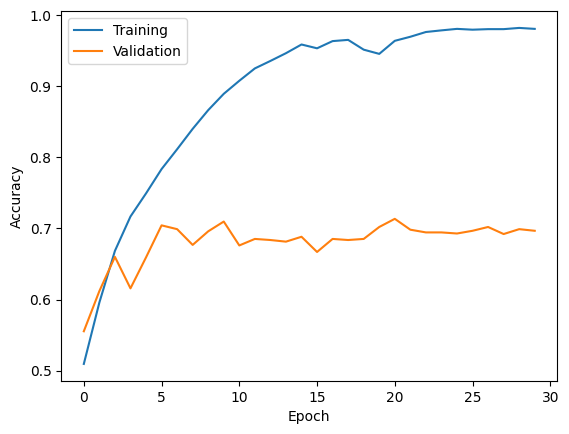

In [37]:
import matplotlib.pyplot as plt

plt.plot(model.training_evals, label='Training')
plt.plot(model.val_evals, label='Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [38]:
model.score(val_loader)

0.6967150496562261

The final validation accuracy was therefore: $69.67\%$

Evidently, the model overfits to the training data. The complexity of the model results in the model memorizing the labels opposed to learning how to correctly classify the tweets. The validation accuracy being so much less than the training error indicates poor generalization and a need to decrease to complexity of the model. To confirm whether the model has poor generalization, lets compute that test accuracy of the model. The next section will do exactly that, first by making use of pretrained embedding vectors and then by adding regularization to the model.

### Pretrained embeddings

The embeddings of the words is an important aspect of a NLP model. As mentioned earlier, embeddings of words with similar meanings should be similar or close to each other in the vector space they are in. The similarity between these vectors is usually calculated as a distance, such as Euclidean distance. In the previous model, each word in the vocab was initialized to a random vector by the embedding layer. The model then had to learn the best transformation of words to vectors from the data. Due to how small the data set is, it is unlikely that the final embedding layer accurately transformed similar words into similar vectors. One solution to this would be to gain more data to train the embedding layer on. This solution is usually expensive as it would involve a process to collect new data such as web scraping and then the tweets would have to be labeled. Another solution is pre-trained embeddings! Although there are many sources of pre-trained embeddings out there, Pytorch provides a quick means of downloading and using a couple of different embedding datasets. For more on the embeddings provided by Pytorch, check out [this link](https://pytorch.org/text/stable/vocab.html#fasttext). The embedding dataset used here is one of the Twitter datasets from [GloVe](https://nlp.stanford.edu/projects/glove/): Global Vectors for word representation. Specifically, the dataset of $27$ billion tokens (words), that are represented as $25$-dimensional embedding vectors.

The first time this is run, it will download the dataset of embeddings. If run again, the downloaded dataset will be detected and used. From the downloaded embeddings, a vocabulary can be constructed. An extra entry is added to account an unknown token.

In [39]:
from torchtext.vocab import GloVe, vocab

twitter_vectors = GloVe(name='twitter.27B', dim=25)
unk_index = 0
v = vocab(twitter_vectors.stoi)
v.insert_token("<unk>", unk_index)
v.set_default_index(unk_index)

pretrained_embeddings = twitter_vectors.vectors
pretrained_embeddings = torch.cat((
    torch.zeros(1,pretrained_embeddings.shape[1]),
     pretrained_embeddings))

Luckly, the only changes that need to be made to the `DisasterTweet` code is the code for initializing the embedding layer. These changes include changes to the constructor of the model. To avoid repeating code, a new class can be created that inherits from the `DisasterTweet` class. This new class can then replace the old embedding layer with one that uses the pretrained vectors. The following is added below the code for `DisasterTweet`. Again, all the code for these models can be found in `nlp_models.py`.

In [40]:
%%script echo skipping

class EmbeddingModel(DisasterTweet):
    
    def __init__(self, vocab, pretrained_embeds, hidden_dim, lr=0.1, device=None):
        
        super(EmbeddingModel, self).__init__(vocab, 
                                             pretrained_embeds.shape[1], 
                                             hidden_dim, lr=lr, device=device)
        
        self.embedding_layer = Embedding.from_pretrained(
            pretrained_embeds, 
            freeze=False,
        )
        
        if device:
            self.to(device)

skipping


With the above changes, we can now train a model using the pretrained embedding vectors and examine its performance.

In [41]:
from src.nlp_models import EmbeddingModel

model_pretrained = EmbeddingModel(v, pretrained_embeddings, 10, device=device)

model_pretrained.fit(train_loader, val_loader, epochs=30)

[   0 - 500]	Loss: 353.7423	Time: 1.8686s
[   0 - 1000]	Loss: 700.1653	Time: 3.5872s
[   0 - 1500]	Loss: 1037.2399	Time: 5.1999s
[   0 - 2000]	Loss: 1382.9846	Time: 6.8273s
[   0 - 2500]	Loss: 1728.2152	Time: 8.4567s
[   0 - 3000]	Loss: 2062.3071	Time: 10.1155s
[   0 - 3500]	Loss: 2390.4783	Time: 11.7360s
[   0 - 4000]	Loss: 2727.7400	Time: 13.3485s
[   0 - 4500]	Loss: 3042.8794	Time: 14.9683s
[   0 - 5000]	Loss: 3365.2065	Time: 16.5853s
Epoch: 0	Loss: 3517.7053	Time: 17.3366s
[   1 - 500]	Loss: 329.1932	Time: 1.7080s
[   1 - 1000]	Loss: 648.8672	Time: 3.3359s
[   1 - 1500]	Loss: 982.2354	Time: 4.9542s
[   1 - 2000]	Loss: 1305.6051	Time: 6.5756s
[   1 - 2500]	Loss: 1623.5012	Time: 8.1951s
[   1 - 3000]	Loss: 1944.5725	Time: 9.8451s
[   1 - 3500]	Loss: 2265.9844	Time: 11.6472s
[   1 - 4000]	Loss: 2590.5920	Time: 13.3631s
[   1 - 4500]	Loss: 2900.0898	Time: 15.1052s
[   1 - 5000]	Loss: 3231.7888	Time: 16.8260s
Epoch: 1	Loss: 3380.4265	Time: 17.5921s
[   2 - 500]	Loss: 299.2503	Time: 1.71

In [ ]:
plt.plot(model_pretrained.training_evals, label='Training')
plt.plot(model_pretrained.val_evals, label='Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [43]:
model_pretrained.score(val_loader)

0.6822001527883881

The final validation accuracy was therefore: $68.52\%$

Unfortunately, the results do not support the hypothesis that using pretrained embeddings will improve on the model's performance. However, the training accuracy did drop below $90\%$. Although this may not seem like a good thi, what it means that the model did not overfit as much as the previous model. The performance of any machine learning model is problem dependent. Commonly known as the no-free-lunch theorem, there is no single model that fits well to every problem. So although these pretrained embeddings did not improve the performance for this problem, they may still provide benefits for other problems. What is important is that one tries multiple methods and configurations to find what best suits a problem. 

### Regularization

Based on the large difference between the training accuracy and the validation accuracy for the original base case `DisasterTweet` model, it is evident that this model is overfitting to the data. When this happens, it is usualy because the model has too many parameters and has too many degrees of freedom. This allows the model to learn the noise of the training data or to memorize the training data instead of generalizing. A common solution to overfitting is regularization. Regularization usually penalizes a model for being overly complicated and thus encourages the model generalize rather than specialize to the training data. There are two methods of regularization that we will use here.

The first is weight decay. This method affects the loss function by adding to the loss when there are large values for the weights. This will encourage the model to use smaller weights which will hopefully reduce the complexity. Although this method affects the loss of the model, to implement it in `Pytorch`, it is the optimizer that needs to be changed. For both regularization methods, a single new model will be created. This model will also inherit from `DisasterTweets` and will use constructor parameters to define the reguarlization used. The following can be added below the code for `EmbeddingModel`:

In [76]:
%%script echo skipping

class RegularizationModel(DisasterTweet):
    
    def __init__(self, vocab, embedding_dim, hidden_dim, weight_decay=0, lr=0.1, device=None):
        
        self.optimizer = SGD(self.parameters(), weight_decay=weight_decay, lr=lr)
        
        if device:
            self.to(device)

skipping


After a couple of tries, a good value for the weight decay parameter is the small value of $0.0005$.

In [49]:
from src.nlp_models import RegularizationModel

reg_wd_model = RegularizationModel(twitter_vocab, 10, 10, weight_decay=0.0001, device=device)

reg_wd_model.fit(train_loader, val_loader, epochs=30)

[   0 - 500]	Loss: 351.3769	Time: 0.7071s
[   0 - 1000]	Loss: 702.1085	Time: 1.4028s
[   0 - 1500]	Loss: 1053.3529	Time: 2.0837s
[   0 - 2000]	Loss: 1403.0038	Time: 2.7368s
[   0 - 2500]	Loss: 1752.1543	Time: 3.3802s
[   0 - 3000]	Loss: 2099.9390	Time: 4.0874s
[   0 - 3500]	Loss: 2447.1377	Time: 4.7725s
[   0 - 4000]	Loss: 2791.0251	Time: 5.4495s
[   0 - 4500]	Loss: 3131.1221	Time: 6.1392s
[   0 - 5000]	Loss: 3467.0867	Time: 6.8158s
Epoch: 0	Loss: 3631.2173	Time: 7.1331s
[   1 - 500]	Loss: 319.3493	Time: 0.7029s
[   1 - 1000]	Loss: 657.8815	Time: 1.4050s
[   1 - 1500]	Loss: 980.7971	Time: 2.2015s
[   1 - 2000]	Loss: 1319.8457	Time: 2.9722s
[   1 - 2500]	Loss: 1651.7003	Time: 3.7523s
[   1 - 3000]	Loss: 1984.8033	Time: 4.5931s
[   1 - 3500]	Loss: 2303.2859	Time: 5.3804s
[   1 - 4000]	Loss: 2617.5483	Time: 6.1453s
[   1 - 4500]	Loss: 2934.8738	Time: 6.8931s
[   1 - 5000]	Loss: 3257.5562	Time: 7.5705s
Epoch: 1	Loss: 3404.3362	Time: 7.8877s
[   2 - 500]	Loss: 296.7065	Time: 0.6732s
[   2 -

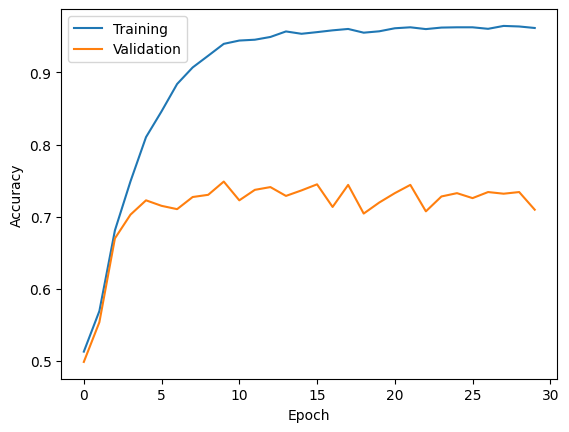

In [45]:
plt.plot(reg_wd_model.training_evals, label='Training')
plt.plot(reg_wd_model.val_evals, label='Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [48]:
reg_wd_model.score(val_loader)

0.7097020626432391

The above results are somewhat confusing. On one hand, the training accuracy is still extremely high and indicates overfitting. On the other hand, the validation accuracy has increased by $5\%$! Later, the test results will be able to indicate whether this regularization truly made a difference.

The second method is called dropout. At layers where dropout is applied, nodes have a certain probability of producing a zero during the feed forward method of the model and will therefore not form part of the network. The effect of this is that instead of a single network specializing to all the data, many subnetworks will be exposed to subsets of the data and will train on those subsets. In the end, the final model is a combination of the submodels. Although the submodels will have high variance and are likely to overfit to the subsets of data they are exposed to, the combination of these submodels will have much less variance. This lower variance hopefully reduces the overfitting of the model and improves the performance. The following code can be added after the call to the super class constructor in `RegularizationModel`:

In [80]:
%%script echo skipping

self.dropout = Dropout(dropout_prob)

skipping


where `dropout_prob` is a new parameter in the constructor of `RegularizationModel`. For this, the following import can also be added to the file:

In [81]:
from torch.nn import Dropout

To have dropout at the fully connected layer, this dropout layer needs to be added just before the call to the `fc` layer in the `forward` method:

In [82]:
%%script echo skipping

x = self.dropout(hidden_state.squeeze())
x = self.fc(x)

skipping


To see how all of this code fits together, check out the `RegularizationModel` in `nlp_models.py`

In [55]:
from src.nlp_models import RegularizationModel

reg_do_model = RegularizationModel(twitter_vocab, 10, 10, dropout_prob=0.5, device=device)

reg_do_model.fit(train_loader, val_loader, epochs=30)

[   0 - 500]	Loss: 349.1063	Time: 0.6856s
[   0 - 1000]	Loss: 700.1909	Time: 1.3519s
[   0 - 1500]	Loss: 1051.5804	Time: 2.0306s
[   0 - 2000]	Loss: 1403.7556	Time: 2.7164s
[   0 - 2500]	Loss: 1753.5742	Time: 3.3449s
[   0 - 3000]	Loss: 2101.7002	Time: 4.0295s
[   0 - 3500]	Loss: 2452.6077	Time: 4.6975s
[   0 - 4000]	Loss: 2804.2368	Time: 5.3599s
[   0 - 4500]	Loss: 3152.7344	Time: 6.0205s
[   0 - 5000]	Loss: 3499.0654	Time: 6.6870s
Epoch: 0	Loss: 3661.6372	Time: 7.0071s
[   1 - 500]	Loss: 347.8384	Time: 0.7467s
[   1 - 1000]	Loss: 693.4699	Time: 1.4580s
[   1 - 1500]	Loss: 1037.8701	Time: 2.1682s
[   1 - 2000]	Loss: 1389.3254	Time: 2.8675s
[   1 - 2500]	Loss: 1738.4559	Time: 3.5459s
[   1 - 3000]	Loss: 2081.0664	Time: 4.2385s
[   1 - 3500]	Loss: 2425.5024	Time: 4.9537s
[   1 - 4000]	Loss: 2770.3560	Time: 5.6560s
[   1 - 4500]	Loss: 3114.4790	Time: 6.3924s
[   1 - 5000]	Loss: 3467.0591	Time: 7.0897s
Epoch: 1	Loss: 3625.2424	Time: 7.4116s
[   2 - 500]	Loss: 344.4629	Time: 0.6814s
[   2 

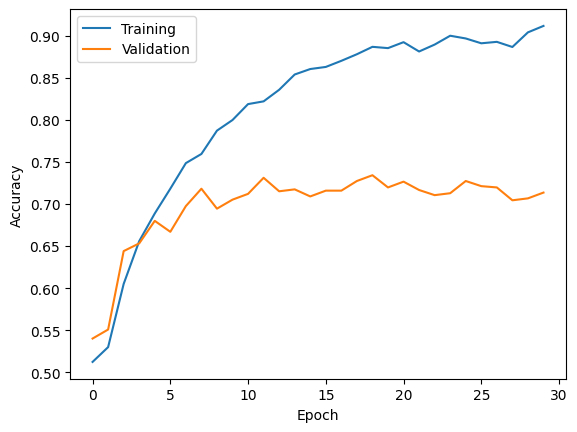

In [56]:
plt.plot(reg_do_model.training_evals, label='Training')
plt.plot(reg_do_model.val_evals, label='Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [57]:
reg_do_model.score(val_loader)

0.7303284950343774

Again, there has been little to no real improvement on the validation data. However, like with the pre-trained embeddings model, the training accuracy has decreased indicating less overfitting.

The final model that is considered uses both of the discussed regularization methods.

In [51]:
reg_model = RegularizationModel(twitter_vocab, 10, 10, weight_decay=0.0005, dropout_prob=0.5, device=device)

reg_model.fit(train_loader, val_loader, epochs=30)

[   0 - 500]	Loss: 353.3240	Time: 0.7253s
[   0 - 1000]	Loss: 703.8973	Time: 1.4433s
[   0 - 1500]	Loss: 1050.8859	Time: 2.1559s
[   0 - 2000]	Loss: 1402.3617	Time: 2.9155s
[   0 - 2500]	Loss: 1752.1816	Time: 3.5814s
[   0 - 3000]	Loss: 2102.6052	Time: 4.2573s
[   0 - 3500]	Loss: 2452.1292	Time: 5.0008s
[   0 - 4000]	Loss: 2801.8425	Time: 5.7312s
[   0 - 4500]	Loss: 3152.2876	Time: 6.4586s
[   0 - 5000]	Loss: 3494.7324	Time: 7.1648s
Epoch: 0	Loss: 3656.6086	Time: 7.4971s
[   1 - 500]	Loss: 350.8919	Time: 0.7044s
[   1 - 1000]	Loss: 697.1713	Time: 1.4144s
[   1 - 1500]	Loss: 1042.9305	Time: 2.1267s
[   1 - 2000]	Loss: 1389.1431	Time: 2.8794s
[   1 - 2500]	Loss: 1735.4132	Time: 3.6275s
[   1 - 3000]	Loss: 2085.3696	Time: 4.4113s
[   1 - 3500]	Loss: 2426.7104	Time: 5.2327s
[   1 - 4000]	Loss: 2763.7651	Time: 5.9683s
[   1 - 4500]	Loss: 3104.5400	Time: 6.7748s
[   1 - 5000]	Loss: 3429.4487	Time: 7.5355s
Epoch: 1	Loss: 3588.7590	Time: 7.9203s
[   2 - 500]	Loss: 330.2926	Time: 0.7035s
[   2 

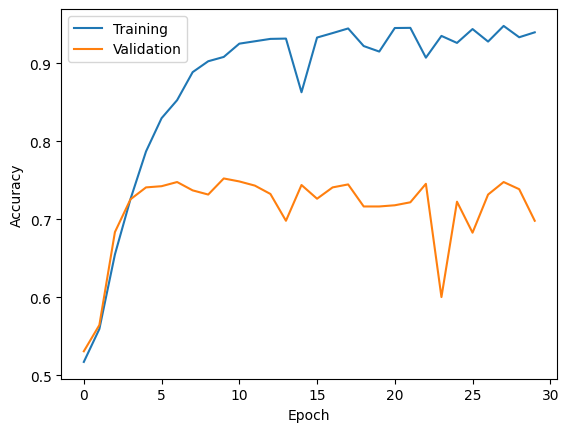

In [52]:
plt.plot(reg_model.training_evals, label='Training')
plt.plot(reg_model.val_evals, label='Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [53]:
reg_model.score(val_loader)

0.7035905271199389

The combined regularization methods increase the validation accuracy to $70.35\%$.

## Test results

The Kaggle competition from which the data is taken from provide a test dataset. However, this dataset does not contain any labels. The point of this dataset is to make predictions and upload these predictions to the Kaggle website. These predictions are then compared to the true labels of the test set and a test accuracy is reported. To make the predictions, a final method is added to the `DisasterTweet` class:

In [32]:
%%script echo skipping

def predict(self, sentences):
        
        all_preds = []
        
        with torch.no_grad():
            for sentence in sentences:
                out = self(sentence)
                
                predict = int(torch.round(torch.sigmoid(out)).item())
                
                all_preds.append(predict)
                
        return all_preds

skipping


A helper function that takes a model and saves the predictions is also useful:

In [61]:
def save_predictions(model, model_name):
    submission_df = pd.DataFrame(model.predict(test_df['cleaned']),
                                 columns=['target'], index=test_df.index)
    submission_df.to_csv(f"../data/{model_name}-submission.csv")
    
    print("Submission saved")

models = [model, model_pretrained, reg_wd_model, reg_do_model, reg_model]
names = ['base-model', 'pretrained-embeds', 'wd-model', 'do-model', 'wd-do-model']

for model, name in zip(models, names):
    save_predictions(model, name)

Submission saved
Submission saved
Submission saved
Submission saved
Submission saved


Based on these submissions, the kaggle test results are:

base-model: $70.76\%$<br>
pretrained-embeds: $67.42\%$<br>
reg-wd-model: $72.91\%$<br>
reg-do-model: $69.51\%$<br>
reg-model: $68.19\%$


## Conclusion of results

Unfortunately, the results of the attempted improvements did not show a substantial amount of improvement from the first basic implementation. Does does not however rule out neural networks and LSTMs as good candidates for this problem. This tutorial intended on exploring some common approaches to increasing the performance of a machine learning model. Even among the common approaches, the ones shown here are a small subset. Other ideas for increasing performance could be to tune the learning rate parameter, change the number of LSTM and fully connected layers and add dropout to the LSTM layers. Changing the model is not the only thing that can be done. Although not explored in this tutorial, the data comes with two more features: `keyword` and `location`. Although not every entry in the dataset contains these added fields, including these features could improve the accuracy for the data instances that do contain values for these fields.

Despite the shortcommings of the results, the approaches investigated and principles discussed are general to many machine learning applications. While these approaches did not drastically increase performance for this problem, it is very possible that these approaches can bring about large increases in performances for other problems.